In [30]:
import requests
import PIL
import ipyplot
import torch
import torchvision.transforms as transform
from torchvision.utils import draw_bounding_boxes

# Applicability of pretrained models - Face Detection

## Face Detection in DeepDetect

For local installation see Installation Guide.

With DeepDetect you can register models as services to run prediction tasks from a client by sending requests to a RESTful API.

To use a pretrained model for face detection as a service, you can use the following code

In [10]:
#activate face detection service

url = "http://localhost:9998/services/faces3" #replace host and port if necessary

payload = {
    "description": "face detection service",
    "model": {
        "repository": "/opt/models/faces",
         "create_repository": True,
         "init":"https://deepdetect.com/models/init/desktop/images/detection/faces_512.tar.gz"
    },
    "mllib": "caffe",
    "type": "supervised",
    "parameters": {
        "input": {
            "connector": "image"
        }
    }
}

response = requests.request("PUT", url, json=payload)
assert response.status_code == 201 # success

In [15]:
#prepare payload prediction

predictPayload_faces = {
  "service": "faces",
  "parameters": {
    "input": {},
    "output": {
      "confidence_threshold": 0.4,
      "bbox": True
    },
    "mllib": {
      "gpu": True
    }
  }
}

In [18]:
#prepare and check image data

predictPayload = predictPayload_faces
sampleURL = "https://upload.wikimedia.org/wikipedia/commons/d/db/Universal_facial_expressions.jpg"
predictPayload["data"] = [sampleURL]


ipyplot.plot_images([sampleURL])

In [20]:
#send prediction to the server
r = requests.post("http://localhost:9998/predict", json=predictPayload)
if r.ok:
    predictresult = r.json()
else:
    print(r.text) #something went wrong, check the error

In [21]:
#check result
predictresult

{'status': {'code': 200, 'msg': 'OK'},
 'head': {'method': '/predict', 'service': 'faces', 'time': 309.0},
 'body': {'predictions': [{'classes': [{'bbox': {'ymax': 428.28729248046875,
       'xmax': 759.752197265625,
       'ymin': 342.1957092285156,
       'xmin': 694.8928833007812},
      'prob': 0.9999159574508667,
      'cat': '1'},
     {'bbox': {'ymax': 148.92562866210938,
       'xmax': 866.5292358398438,
       'ymin': 64.01225280761719,
       'xmin': 803.15869140625},
      'prob': 0.9998891353607178,
      'cat': '1'},
     {'bbox': {'ymax': 419.6234130859375,
       'xmax': 268.35174560546875,
       'ymin': 332.1914367675781,
       'xmin': 205.09793090820312},
      'prob': 0.9998576641082764,
      'cat': '1'},
     {'bbox': {'ymax': 152.51211547851562,
       'xmax': 623.5089111328125,
       'ymin': 73.14198303222656,
       'xmin': 563.539306640625},
      'prob': 0.9998553991317749,
      'cat': '1'},
     {'bbox': {'ymax': 143.82321166992188,
       'xmax': 136.1945

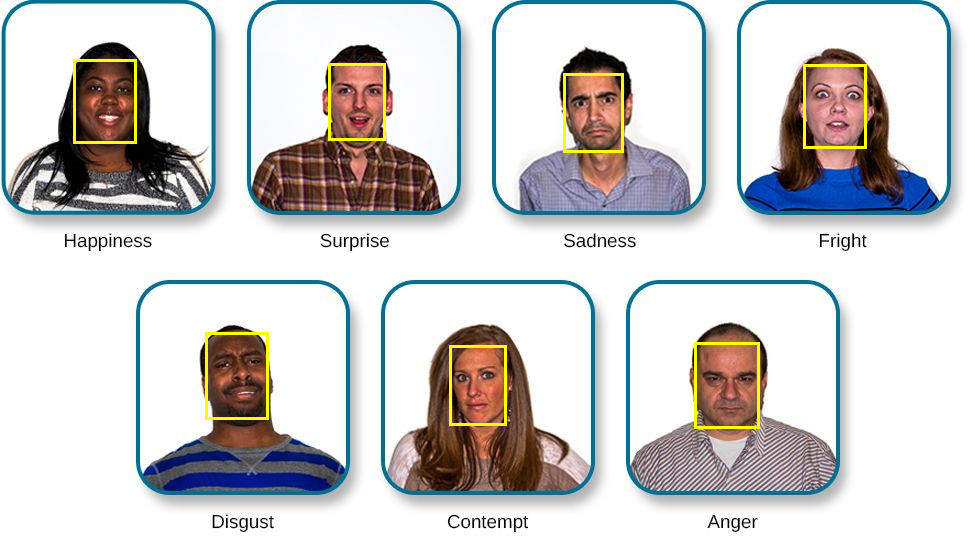

In [36]:
#draw results on requested image

def getBoxesFromPrediction(predictresult, k=0):
    results = predictresult["body"]["predictions"][k]["classes"]
    if results:
        bboxList = [[c["bbox"]["xmin"], c["bbox"]["ymin"], c["bbox"]["xmax"], c["bbox"]["ymax"]] for c in results]
        bbox = torch.tensor(bboxList)

        if len(bboxList) == 1: bbox.unsqueeze(0)
        return bbox
    return []

def drawPredictionBoxes(predictresult, k=0):
    imgurl = predictresult["body"]["predictions"][k]["uri"]
    if predictPayload["parameters"]["output"].get("bbox") and len(getBoxesFromPrediction(predictresult, k)):
        PIL_image = PIL.Image.open(requests.get(imgurl, stream=True).raw)
        img = transform.functional.pil_to_tensor(PIL_image)
        imgwb = draw_bounding_boxes(img, getBoxesFromPrediction(predictresult), width=3, colors=(255,255,0))
        pimg = transform.ToPILImage()(imgwb)
        display(pimg)
    else: print("no boxes to draw")

drawPredictionBoxes(predictresult)

## Example 1: Die Gartenlaube

The journal 'Die Gartenlaube - Illustriertes Familienblatt' (lit. The Garden Arbor / Gazebo) was the first widely successful mass magazine in Germany. It was funded in 1853 and provided a mixture of events, science essays, short stories and illustrations. It was published in weekly issues, aiming to be read by middle class families. Since 2008 the Gartenlaube is transcribed in the Citizen Science Project "[Die Datenlaube](https://zenodo.org/record/3859555)", involving Wikisource/Wikidata.



### Image Data: IIIF

Some of the volumes are [digitized by Bayerische Staatsbibliothek](https://www.digitale-sammlungen.de/en/search?filter=volumes%3A%22bsb10498427%2FBV002554411%22), commonly available by IIIF

As a data example we take a closer look at [Die Gartenlaube 1864,1](https://www.digitale-sammlungen.de/en/view/bsb10498427?page=,1), IIIF Manifest: https://api.digitale-sammlungen.de/iiif/presentation/v2/bsb10498427/manifest

To get an overview and direct links to the images, the [IIIF Manifest Explorer](https://www.lizmfischer.com/iiif-tools/manifest) might be handy.

Reminder: iiif-Images can be downscaled, rotated and cropped by manipulating the URL.

URL-Format: `.../{iiif-identifier}/{region by x,y,w,h}/{size by w,h}/{rotation by degree}/{return type}.jpg`

### Exercise

Write the necessary code for the following exercises. Reuse `getBoxesFromPrediction(url)` and `drawPredictionBoxes(predictionjson)` if necessary.

- Select an illustrated page from the Gartenlaube journal by image URL
- Optional: Manipulate to your needs (resize, crop, etc.)
- Let the model predict faces on your selected image
- Draw detected faces on the image to check the results

Repeat the steps above with different images to determine the following:

- How well are faces detected if present?
- How often are things detected as faces that are not really faces
- How do your IIIF image manipulation parameters influence the results?

In [37]:
### INSERT CODE FOR EXERCISE ###

## Example 2: Biblische Figuren - biblical pictures from the 16th century

In the 16th century, the city of Frankfurt am Main in Germany became the 'capital of illustrated book printing'. Multiple printers and publishers started focusing on illustrated books, hiring well known artists to create the blueprints for their woodcut illustrations. Even picture books with only small amount of texts and large illustrations came in fashion, becoming also somewhat affordable due to the possibilities of the newly invented printing techniques.


### Image Data: IIIF

One example of a biblical picture book can be found in:
[Amman, Jost: Neuwe biblische Figuren deß Alten und Neuwen Testaments ()](https://www.digitale-sammlungen.de/en/view/bsb11708135), printed by Georg Rab, Sigmund Feyerabend and Weigand Han (heirs), Frankfurt/Main 1565

IIIF-Manifest: https://api.digitale-sammlungen.de/iiif/presentation/v2/bsb11708135/manifest

### Exercise

Redo the steps above on the second example to determine the performance of the face detection model on 16th century woodcut illustrations.

In [39]:
### INSERT CODE FOR EXERCISE ###